In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import pyro
import pyro.infer
import pyro.optim as optim
import pyro.distributions as dist
import torch
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLaplaceApproximation, AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer.mcmc.util import diagnostics, print_summary
import torch.distributions.constraints as constraints
import pyro.ops.stats as stats

In [13]:
df = pd.read_csv('harmonized_imaging_data_copy.csv')
df.head()

,Unnamed: 0,Subject,Image_Data_ID,Acq_Date,Scanner_Proxy,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,...,lhCortexVol,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,SupraTentorialVolNotVent
0,1,941_S_1202,I105437,2/28/08,1.5T 127,2.293995,2.374323,2.365546,1.751561,2.373949,...,231261.0718,226643.6623,458116.9003,229653.3751,232860.8157,462147.3988,52237.97241,630374.4167,1032767.420,969624.3118
1,2,941_S_1202,I204843,3/14/10,1.5T 127,2.238152,2.370227,2.422323,1.572415,2.374845,...,222285.3747,221789.4320,444007.0776,222318.8233,221394.6305,443873.6731,49803.50531,608232.5781,1007836.483,938244.5481
2,3,941_S_1202,I137298,2/17/09,1.5T 127,2.341442,2.395378,2.395351,1.636999,2.512835,...,228568.9496,225358.1318,454037.1988,225469.1693,224917.4967,450418.2728,51986.27958,624463.5994,1018251.672,954353.3369
3,4,941_S_1202,I63874,1/30/07,1.5T 127,2.376226,2.472983,2.485934,1.706193,2.557352,...,237561.5588,235971.1950,473442.2905,228115.4344,229646.0314,457612.6977,53501.33559,647779.4638,1042491.029,981522.7094
4,5,941_S_1202,I75150,8/24/07,1.5T 127,2.410585,2.396323,2.430674,1.730468,2.533913,...,234224.5307,230850.6554,465165.1741,224456.7820,222782.1702,447466.4965,53584.05077,636336.5366,1025783.337,965057.4086


In [14]:
list(df.columns)

['Unnamed: 0',
 'Subject',
 'Image_Data_ID',
 'Acq_Date',
 'Scanner_Proxy',
 'lh_bankssts_thickness',
 'lh_caudalanteriorcingulate_thickness',
 'lh_caudalmiddlefrontal_thickness',
 'lh_cuneus_thickness',
 'lh_entorhinal_thickness',
 'lh_fusiform_thickness',
 'lh_inferiorparietal_thickness',
 'lh_inferiortemporal_thickness',
 'lh_isthmuscingulate_thickness',
 'lh_lateraloccipital_thickness',
 'lh_lateralorbitofrontal_thickness',
 'lh_lingual_thickness',
 'lh_medialorbitofrontal_thickness',
 'lh_middletemporal_thickness',
 'lh_parahippocampal_thickness',
 'lh_paracentral_thickness',
 'lh_parsopercularis_thickness',
 'lh_parsorbitalis_thickness',
 'lh_parstriangularis_thickness',
 'lh_pericalcarine_thickness',
 'lh_postcentral_thickness',
 'lh_posteriorcingulate_thickness',
 'lh_precentral_thickness',
 'lh_precuneus_thickness',
 'lh_rostralanteriorcingulate_thickness',
 'lh_rostralmiddlefrontal_thickness',
 'lh_superiorfrontal_thickness',
 'lh_superiorparietal_thickness',
 'lh_superiortem

## Univariate Bayesian Linear Regression
#### Predict hippocampus volume from amygdala volume

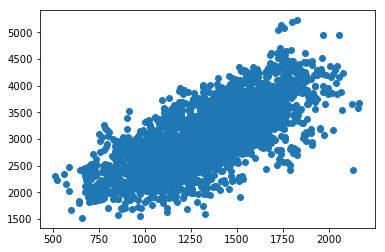

In [15]:
plt.scatter(df['Right_Amygdala'], df['Left_Hippocampus'])

$$h_{i} \sim  Normal(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha + \beta(x_i - \bar{x} ) $$
$$\alpha \sim Normal(2500, 1000)$$
$$\beta \sim Normal(0,10)$$
$$\sigma \sim Uniform(0,1000)$$

In [19]:
pyro.clear_param_store()

h_vol, a_vol = torch.tensor(df['Left_Hippocampus'].values), torch.tensor(df['Left_Amygdala'].values)
xbar = a_vol.mean()

#Model: height ~ Normal(alpha + beta * weight, sigma)
def model(a_vol, h_vol):
    alpha = pyro.sample("alpha", dist.Normal(torch.tensor(2500.), torch.tensor(2000.)))
    beta = pyro.sample("beta", dist.Normal(torch.tensor(0.), torch.tensor(10.)))
    sigma = pyro.sample("sigma", dist.Uniform(0,1000))
    
    mu = pyro.deterministic("mu", alpha + beta * (a_vol - xbar))
    with pyro.plate("plate"):
        pyro.sample("h_vol", dist.Normal(mu, sigma), obs = h_vol)


guide = AutoDiagonalNormal(model)

adam_params = {"lr": .05}
svi = SVI(model, guide, optim.Adam(adam_params), Trace_ELBO())
n_steps = 3000
for step in range(n_steps):
    svi.step(a_vol, h_vol)
    if step % 100 == 0:
        print('.', end='')

..............................

In [20]:
guide.quantiles([0.25, 0.5, 0.75])

{'alpha': [tensor(3173.7307), tensor(3177.1296), tensor(3180.5286)],
 'beta': [tensor(1.8022), tensor(1.8228), tensor(1.8433)],
 'sigma': [tensor(394.0201), tensor(397.0705), tensor(400.1289)]}

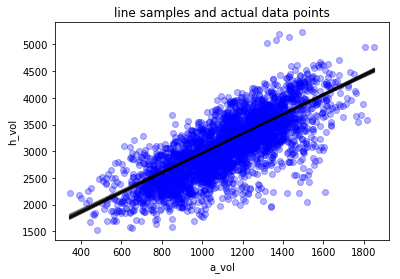

In [21]:
x = np.linspace(a_vol.numpy().min(), a_vol.numpy().max(), 101)
num_lines = 20

#Sample guide in the constrained space
predictive = Predictive(guide, num_samples = num_lines, return_sites=("alpha", "beta", "sigma"))
samples = predictive()



for w,h in zip(a_vol,h_vol):
    plt.plot(w,h,'o', color = 'blue', alpha = .3)

for i in range(num_lines):
    plt.plot(x, samples['alpha'][i] + samples['beta'][i]*(x-xbar.item()), "k", alpha = 0.3)

plt.xlabel('a_vol')
plt.ylabel('h_vol')
plt.title('line samples and actual data points')
plt.show()

/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '89% posterior distribution of mu')

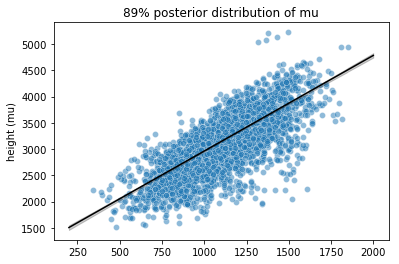

In [30]:
n_samples = 1000
predictive = Predictive(model, guide=guide, num_samples = n_samples)
a_seq = torch.arange(200.,2000)
samples = predictive(a_seq, None)
mu = samples['mu'].squeeze()
mu_mean = mu.mean(0)
mu_HPDI = stats.hpdi(mu, prob=0.89, dim=0)


sns.scatterplot(a_vol.numpy(), h_vol.numpy(),  alpha=0.5)
# plot the MAP line, aka the mean mu for each weight
ax = sns.lineplot(a_seq, mu_mean, color="k")
plt.ylabel('height (mu)')
# plot a shaded region for 89% HPDI
ax.fill_between(a_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2);
plt.title('89% posterior distribution of mu')

In [27]:
h  = samples['h_vol']
h_mean = mu.mean(0)
h_HPDI = stats.hpdi(h, prob=0.89, dim=0)

/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


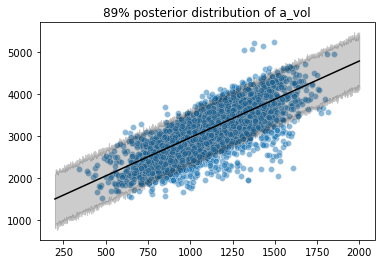

In [32]:
sns.scatterplot(a_vol.numpy(), h_vol.numpy(),  alpha=0.5)
# plot the MAP line, aka the mean mu for each weight
ax = sns.lineplot(a_seq, mu_mean, color="k")
# plot a shaded region for 89% HPDI
ax.fill_between(a_seq, h_HPDI[0], h_HPDI[1], color="k", alpha=0.2);
plt.title('89% posterior distribution of a_vol')
plt.show()